### Imports et initialisations

In [1]:
import numpy as np
# Pour l'échantillonnage aléatoire
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from clustertools import *

In [2]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/1M_Std_clusters/"
clean_dataset_file = "datasets/MillionTweetsStd_NEFU.txt"
raw_dataset_file = "datasets/MillionTweets_NEFU.txt"

### Chargement des données en mémoire

In [3]:
with open(clean_dataset_file, "r") as file:
    lines = file.read().splitlines()
    
clean_dataset = [line.split() for line in lines]

with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()

### Création des échantillons
Ne pas exécuter pour travailler avec toutes les données

In [6]:
sample_size = 5000

idx_list = random.sample(range(len
                               (clean_dataset)), sample_size)
clean_dataset = [clean_dataset[i] for i in idx_list]
raw_dataset = [raw_dataset[i] for i in idx_list]

### Encodage du jeu de données

On charge le modèle depuis le disque

In [4]:
from gensim.models import KeyedVectors

In [5]:
model = KeyedVectors.load("models/w2vec_model_d300_1M_Std")
dim = 300

In [6]:
# Encode un message
# msg : liste de chaînes de caractères correspondant aux mots du message
# model : le modèle utilisé pour l'encodage
# dim : la dimension des vecteurs mots dans ce modèle
# Renvoie un vecteur qui est la moyenne de tous les vecteurs correspondants aux mots du message
# Si aucun mot du message n'est dans le modèle, renvoie un vecteur de zéros.
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [7]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg, model, dim) for msg in clean_dataset])

CPU times: user 23.1 s, sys: 613 ms, total: 23.7 s
Wall time: 23.7 s


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode PCA

In [8]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 43.1 s, sys: 12 s, total: 55.2 s
Wall time: 9.13 s


In [9]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["lines.markersize"] = 3

In [11]:
# Initialisation des variables globales pour le module clustertools
init_globals(clean_dataset, raw_dataset, two_dim_dataset, cluster_dir)

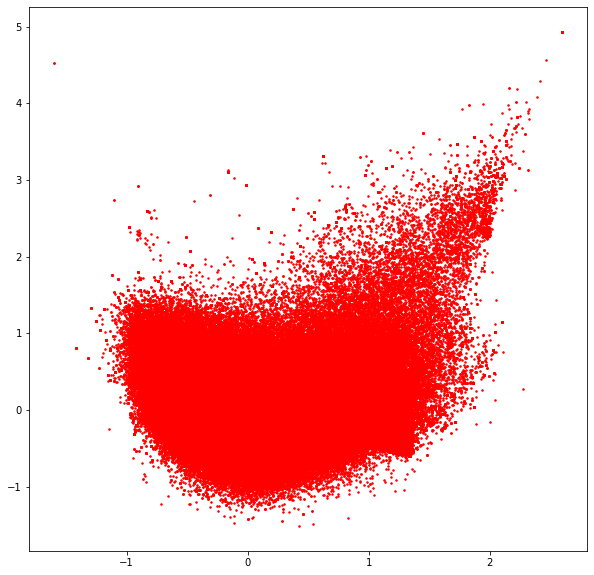

In [12]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

### SOM

In [13]:
from sklearn_som.som import SOM

In [14]:
%%time
som_normalized_dataset = np.array([vect / np.linalg.norm(vect) if np.linalg.norm(vect) != 0 else vect for vect in dataset_encoded])

CPU times: user 9.07 s, sys: 469 ms, total: 9.54 s
Wall time: 9.54 s


In [15]:
%%time

som = SOM(m=60, n=60, dim=300)
som.fit(som_normalized_dataset)

CPU times: user 1h 16min 26s, sys: 8.95 s, total: 1h 16min 35s
Wall time: 1h 16min 39s


In [16]:
%%time

som_pred = som.predict(som_normalized_dataset)

CPU times: user 1h 15min 29s, sys: 9.04 s, total: 1h 15min 38s
Wall time: 1h 15min 41s


In [17]:
%%time

som_centers = [[r[0] for r in model.similar_by_vector(center)] for center in som.weights]

CPU times: user 3min 10s, sys: 36 s, total: 3min 46s
Wall time: 28.9 s


In [18]:
%%time

parse_results(som_pred, "som_3600", som_centers)

Cluster 0 : 9136 messages
29 messages contiennent un mot-clé haineux (soit 0.32%)
Les 20 mots les plus fréquents : amp; projet développ présent engag entrepris journ lutt action programm national président social particip échang économ organis commun cadr servic 
Les mots les plus proches du centre : quelqu'cens scandalous. compassionate#twice#scientist#formulaoflov magnificat amop etiquetart etiquétalo bracelet! bean? m’cru 

Cluster 1 : 3924 messages
11 messages contiennent un mot-clé haineux (soit 0.28%)
Les 20 mots les plus fréquents : social président national réseau polit ministr félicit pay soutien travail économ chef organis élect meilleur conseil union républ européen lutt 
Les mots les plus proches du centre : list veux???? entp!! élect moist! secret etiquetart -chain pouvoir fêm 

Cluster 2 : 4724 messages
32 messages contiennent un mot-clé haineux (soit 0.68%)
Les 20 mots les plus fréquents : pay maroc miss afriqu sénégal alger marocain africain affair viol peupl guerr cult

TypeError: 'NoneType' object is not subscriptable

In [18]:
def parse_no_save(pred, centers=[]):
    res = build_res_dict(pred)
    wlists, mlists, emlists, cmlists, e2dmlists = create_word_and_msg_lists(res)
    ignored = [tup[0] for tup in create_sorted_wlist(clean_sample)[:n_most_freq_ignored]]
    mfw = most_freq_words(n_clust_info, wlists, ignored)
    hkw = search_hate_words(mlists, kw_file)
    clust_n_msg = n_msg_by_clust(res)
    print_clusters_info(clust_n_msg, mfw, hkw, centers)
    plot_results(res)

1

In [30]:
ignored = [tup[0] for tup in create_sorted_wlist(clean_dataset)[:60]]

In [19]:
red = build_res_dict(som_pred)

In [21]:
wlists, mlists, cmlists, e2dmlists = create_word_and_msg_lists(red)

In [38]:
mfw = most_freq_words(20, wlists, ignored)

NameError: name 'ignored' is not defined

In [22]:
hkw = search_hate_words(mlists, "kw_hate.txt")

In [39]:
hkw

[(29, 0.31742556917688264),
 (11, 0.2803261977573904),
 (32, 0.6773920406435224),
 (34, 0.46581723523770374),
 (1, 0.26666666666666666),
 (32, 0.7046905967848491),
 (43, 0.9933009933009933),
 (49, 0.5730323938720617),
 (67, 0.5343754984846067),
 (30, 0.7183908045977011),
 (24, 0.8168822328114363),
 (44, 0.544083096327439),
 (22, 0.8151167098925528),
 (67, 0.6569271497205608),
 (0, 0.0),
 (32, 0.6181186015066641),
 (27, 0.7027589796980739),
 (46, 0.8980866848887153),
 (103, 1.561315749583144),
 (27, 0.390625),
 (49, 0.4920172708103223),
 (40, 0.6780810306831667),
 (52, 1.118279569892473),
 (80, 1.2165450121654502),
 (2, 1.2048192771084338),
 (24, 0.30337504740235116),
 (39, 0.4087193460490463),
 (19, 0.24136178861788618),
 (76, 1.6414686825053995),
 (110, 1.7203628401626525),
 (49, 0.8838383838383838),
 (74, 0.7399260073992601),
 (79, 0.577443169358965),
 (55, 0.535436137071651),
 (13, 0.647410358565737),
 (22, 0.7837548984681154),
 (34, 0.3198494825964252),
 (5, 0.13404825737265416),
 

In [40]:
len(raw_dataset)

658009